In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None



In [2]:
aloha = pd.read_csv('results/aloha.csv', encoding='latin-1', converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray})


In [3]:
aloha.head()


run     type module name  \
0  MAM10-BMRELAY-2-20200913-16:56:29-159411  runattr    NaN  NaN   
1  MAM10-BMRELAY-2-20200913-16:56:29-159411  runattr    NaN  NaN   
2  MAM10-BMRELAY-2-20200913-16:56:29-159411  runattr    NaN  NaN   
3  MAM10-BMRELAY-2-20200913-16:56:29-159411  runattr    NaN  NaN   
4  MAM10-BMRELAY-2-20200913-16:56:29-159411  runattr    NaN  NaN   

        attrname               attrvalue  value  count  sumweights  mean  \
0     configname           MAM10-BMRELAY    NaN    NaN         NaN   NaN   
1       datetime       20200913-16:56:29    NaN    NaN         NaN   NaN   
2     experiment           MAM10-BMRELAY    NaN    NaN         NaN   NaN   
3        inifile             omnetpp.ini    NaN    NaN         NaN   NaN   
4  iterationvars  $delta=0, $speedMps=14    NaN    NaN         NaN   NaN   

   stddev  min  max binedges binvalues  
0     NaN  NaN  NaN     None      None  
1     NaN  NaN  NaN     None      None  
2     NaN  NaN  NaN     None      None  
3     NaN  NaN  NaN     None      None  
4     NaN  NaN  NaN     None      None

In [4]:
allAttrs = aloha[(aloha.type == 'itervar')]['attrname'].unique()
allAttrs.sort()
allAttrs

array(['delta', 'speedMps'], dtype=object)

In [5]:
allRelayModes = aloha[(aloha['attrname'].str.contains('.app[0].relayMode', na=False, regex=False))]['attrvalue'].unique()
allRelayModes.sort()
allRelayModes

array(['"BMesh"', '"MAM"'], dtype=object)

In [6]:
allSpeeds = aloha[(aloha.attrname == 'speedMps')]['attrvalue'].unique()
allSpeeds.sort()
allSpeeds

array([2.0, 6.0, 14.0], dtype=object)

In [7]:
allDeltas = aloha[(aloha.attrname == 'delta')]['attrvalue'].unique()
allDeltas.sort()
allDeltas = allDeltas[1:]
allDeltas

array([2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 500.0, 1000.0, 5000.0, 10000.0,
       15000.0, 20000.0], dtype=object)

In [8]:
dataByRun = aloha.groupby(['run'])
dataByRun.size()

run
MAM10-BMRELAY-0-20200913-16:56:21-159411      2545
MAM10-BMRELAY-1-20200913-16:56:26-159411      2544
MAM10-BMRELAY-2-20200913-16:56:29-159411      2543
MAM10-MAMRELAY-0-20200913-16:56:32-159426     2545
MAM10-MAMRELAY-1-20200913-16:56:36-159426     2544
                                             ...  
MAM50-MAMRELAY-5-20200913-16:34:32-158824    11585
MAM50-MAMRELAY-6-20200913-16:34:57-158824    11587
MAM50-MAMRELAY-7-20200913-16:35:33-158824    11587
MAM50-MAMRELAY-8-20200913-16:36:19-158824    11586
MAM50-MAMRELAY-9-20200913-16:36:49-158824    11589
Length: 114, dtype: int64

In [9]:

def findBluetoothRelayRun(speed, configName):
    def testA(x):
        bmeshMatch = x[(x['attrname'].str.contains('.app[0].relayMode', na=False, regex=False))]['attrvalue'].iloc[0] == '"BMesh"'
        speedMatch = x[(x.attrname == 'speedMps')]['attrvalue'].iloc[0] == speed
        configNameMatch = x[(x.attrname == 'configname')]['attrvalue'].iloc[0] == configName
    
        return bmeshMatch & speedMatch & configNameMatch

    s = pd.Series(dataByRun.apply(testA))
    s = s[s == True]
    if len(s) == 0:
        raise Exception("Bluetooth Relay run not found for speed=" + str(speed) + " configName=" + configName)
    if len(s) > 1:
        raise Exception("Bluetooth Relay run duplicate for speed=" + str(speed) + " configName=" + configName)
    return s.index[0]

findBluetoothRelayRun(speed=6, configName='MAM10-BMRELAY')



'MAM10-BMRELAY-1-20200913-16:56:26-159411'

In [10]:

def findMAMRelayRun(speed, delta, configName):
    def testA(x):
        bmeshMatch = x[(x['attrname'].str.contains('.app[0].relayMode', na=False, regex=False))]['attrvalue'].iloc[0] == '"MAM"'
        speedMatch = x[(x.attrname == 'speedMps')]['attrvalue'].iloc[0] == speed
        deltaMatch = x[(x.attrname == 'delta')]['attrvalue'].iloc[0] == delta
        configNameMatch = x[(x.attrname == 'configname')]['attrvalue'].iloc[0] == configName
    
        return bmeshMatch & speedMatch & deltaMatch & configNameMatch

    s = pd.Series(dataByRun.apply(testA))
    s = s[s == True]
    if len(s) == 0:
        raise Exception("MAM Relay run not found for speed=" + str(speed) + " delta=" + str(delta) + " configName=" + configName)
    if len(s) > 1:
        raise Exception("MAM Relay run duplicate for speed=" + str(speed) + " delta=" + str(delta) + " configName=" + configName)
    return s.index[0]

findMAMRelayRun(speed=2, delta=5, configName='MAM50-MAMRELAY')


'MAM50-MAMRELAY-3-20200913-16:33:17-158824'

In [11]:
def getRunData(run):
    return aloha[aloha.run == run]

def getCollectorRunScalars(run):
    runData = aloha[aloha.run == run]
    runData = runData[(runData.type=='scalar')]
    return runData[runData['module'].str.contains('collector1.app')]

getRunData(findBluetoothRelayRun(speed=6, configName='MAM10-BMRELAY'))

run       type  \
237     MAM10-BMRELAY-1-20200913-16:56:26-159411    runattr   
238     MAM10-BMRELAY-1-20200913-16:56:26-159411    runattr   
239     MAM10-BMRELAY-1-20200913-16:56:26-159411    runattr   
240     MAM10-BMRELAY-1-20200913-16:56:26-159411    runattr   
241     MAM10-BMRELAY-1-20200913-16:56:26-159411    runattr   
...                                          ...        ...   
547097  MAM10-BMRELAY-1-20200913-16:56:26-159411  histogram   
547098  MAM10-BMRELAY-1-20200913-16:56:26-159411       attr   
547099  MAM10-BMRELAY-1-20200913-16:56:26-159411       attr   
547100  MAM10-BMRELAY-1-20200913-16:56:26-159411       attr   
547101  MAM10-BMRELAY-1-20200913-16:56:26-159411       attr   

                         module                     name           attrname  \
237                         NaN                      NaN         configname   
238                         NaN                      NaN           datetime   
239                         NaN                      NaN         experiment   
240                         NaN                      NaN            inifile   
241                         NaN                      NaN      iterationvars   
...                         ...                      ...                ...   
547097  MAM10.collector1.app[0]  endToEndDelay:histogram                NaN   
547098  MAM10.collector1.app[0]  endToEndDelay:histogram  interpolationmode   
547099  MAM10.collector1.app[0]  endToEndDelay:histogram             source   
547100  MAM10.collector1.app[0]  endToEndDelay:histogram              title   
547101  MAM10.collector1.app[0]  endToEndDelay:histogram               unit   

                          attrvalue  value   count  sumweights      mean  \
237                   MAM10-BMRELAY    NaN     NaN         NaN       NaN   
238               20200913-16:56:26    NaN     NaN         NaN       NaN   
239                   MAM10-BMRELAY    NaN     NaN         NaN       NaN   
240                     omnetpp.ini    NaN     NaN         NaN       NaN   
241           $delta=0, $speedMps=6    NaN     NaN         NaN       NaN   
...                             ...    ...     ...         ...       ...   
547097                         None    NaN  2831.0         NaN  0.020288   
547098                         none    NaN     NaN         NaN       NaN   
547099      dataAge(packetReceived)    NaN     NaN         NaN       NaN   
547100  end-to-end delay, histogram    NaN     NaN         NaN       NaN   
547101                            s    NaN     NaN         NaN       NaN   

          stddev  min       max  \
237          NaN  NaN       NaN   
238          NaN  NaN       NaN   
239          NaN  NaN       NaN   
240          NaN  NaN       NaN   
241          NaN  NaN       NaN   
...          ...  ...       ...   
547097  0.017425  0.0  0.112217   
547098       NaN  NaN       NaN   
547099       NaN  NaN       NaN   
547100       NaN  NaN       NaN   
547101       NaN  NaN       NaN   

                                                 binedges  \
237                                                  None   
238                                                  None   
239                                                  None   
240                                                  None   
241                                                  None   
...                                                   ...   
547097  [0.0, 0.002, 0.004, 0.006, 0.008, 0.01, 0.012,...   
547098                                               None   
547099                                               None   
547100                                               None   
547101                                               None   

                                                binvalues  
237                                                  None  
238                                                  None  
239                                                  None  
240                             

In [12]:
aloha.iloc[1200:1205]


run     type module name  \
1200  MAM10-MAMRELAY-1-20200913-16:56:36-159426  runattr    NaN  NaN   
1201  MAM10-MAMRELAY-1-20200913-16:56:36-159426  itervar    NaN  NaN   
1202  MAM10-MAMRELAY-1-20200913-16:56:36-159426  itervar    NaN  NaN   
1203  MAM10-MAMRELAY-1-20200913-16:56:36-159426    param    NaN  NaN   
1204  MAM10-MAMRELAY-1-20200913-16:56:36-159426    param    NaN  NaN   

                      attrname attrvalue  value  count  sumweights  mean  \
1200                   seedset         2    NaN    NaN         NaN   NaN   
1201                     delta         2    NaN    NaN         NaN   NaN   
1202                  speedMps         6    NaN    NaN         NaN   NaN   
1203  *.host*.app[0].relayMode     "MAM"    NaN    NaN         NaN   NaN   
1204      *.host*.app[0].delta         2    NaN    NaN         NaN   NaN   

      stddev  min  max binedges binvalues  
1200     NaN  NaN  NaN     None      None  
1201     NaN  NaN  NaN     None      None  
1202     NaN  NaN  NaN     None      None  
1203     NaN  NaN  NaN     None      None  
1204     NaN  NaN  NaN     None      None

In [13]:
aloha.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577573 entries, 0 to 577572
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   run         577573 non-null  object 
 1   type        577573 non-null  object 
 2   module      568489 non-null  object 
 3   name        568489 non-null  object 
 4   attrname    400746 non-null  object 
 5   attrvalue   400746 non-null  object 
 6   value       164197 non-null  float64
 7   count       12630 non-null   float64
 8   sumweights  0 non-null       float64
 9   mean        7692 non-null    float64
 10  stddev      7692 non-null    float64
 11  min         7692 non-null    float64
 12  max         7692 non-null    float64
 13  binedges    10218 non-null   object 
 14  binvalues   10218 non-null   object 
dtypes: float64(7), object(8)
memory usage: 66.1+ MB


In [14]:
aloha.describe()

value         count  sumweights         mean       stddev  \
count  1.641970e+05  12630.000000         0.0  7692.000000  7692.000000   
mean   6.479410e+03   1647.076168         NaN    12.875063    33.243154   
std    1.383883e+05   2291.428041         NaN    53.964674   243.345487   
min   -1.502723e+00      0.000000         NaN     0.000000     0.000000   
25%    0.000000e+00      0.000000         NaN     0.000880     0.006033   
50%    1.000000e+00    664.000000         NaN     0.024100     0.137758   
75%    3.870000e+02   2519.000000         NaN    10.936569     8.729679   
max    8.981389e+06  13848.000000         NaN   678.643815  5796.149969   

                 min           max  
count   7.692000e+03   7692.000000  
mean    4.084040e-01    421.513769  
std     1.567614e+00   4158.958458  
min     0.000000e+00      0.000000  
25%     0.000000e+00      0.111780  
50%    3.523624e-224      1.000000  
75%     1.734019e-01     37.133336  
max     1.404304e+01  79947.620953

In [15]:
scalars = aloha[(aloha.type=='scalar')]
scalars.head()


run    type  \
9084  MAM10-BMRELAY-2-20200913-16:56:29-159411  scalar   
9085  MAM10-BMRELAY-2-20200913-16:56:29-159411  scalar   
9086  MAM10-BMRELAY-2-20200913-16:56:29-159411  scalar   
9087  MAM10-BMRELAY-2-20200913-16:56:29-159411  scalar   
9088  MAM10-BMRELAY-2-20200913-16:56:29-159411  scalar   

                             module                            name attrname  \
9084  MAM10.radioMedium.propagation       Arrival computation count      NaN   
9085              MAM10.radioMedium              transmission count      NaN   
9086              MAM10.radioMedium               signal send count      NaN   
9087              MAM10.radioMedium     reception computation count      NaN   
9088              MAM10.radioMedium  interference computation count      NaN   

     attrvalue     value  count  sumweights  mean  stddev  min  max binedges  \
9084      None   77000.0    NaN         NaN   NaN     NaN  NaN  NaN     None   
9085      None    7700.0    NaN         NaN   NaN     NaN  NaN  NaN     None   
9086      None   77000.0    NaN         NaN   NaN     NaN  NaN  NaN     None   
9087      None   77000.0    NaN         NaN   NaN     NaN  NaN  NaN     None   
9088      None  180999.0    NaN         NaN   NaN     NaN  NaN  NaN     None   

     binvalues  
9084      None  
9085      None  
9086      None  
9087      None  
9088      None

In [16]:
runPrefix = 'MAM50-BMRELAY-0'
run2Prefix = 'MAM50-MAMRELAY-6'

In [17]:
def getScalarSum(scalarName, runData):
    scalarData = runData[(runData.type=='scalar')]
    return scalarData[(scalarData.name==scalarName)]['value'].sum()

energyConsumptionSum = getScalarSum(scalarName='residualEnergyCapacity:last', 
                        runData=getRunData(findBluetoothRelayRun(speed=2, configName='MAM50-BMRELAY')))
energyConsumptionSum

-24.17330952087191

In [18]:
energyConsumption2Sum = getScalarSum(scalarName='residualEnergyCapacity:last', 
                        runData=getRunData(findMAMRelayRun(speed=2, delta=10, configName='MAM50-MAMRELAY')))
energyConsumption2Sum

-22.75039614738272

In [19]:
def getUniqueScalarValue(scalarName, scalarData):
    scalarValue = scalarData[(scalarData.name==scalarName)]['value']

    if len(scalarValue) > 1:
        raise Exception('Scalar ' + scalarName + ' is not unique on this dataframe')
    return scalarValue.iloc[0]

collectorPacketsReceived = getUniqueScalarValue(scalarName='packetReceived:count', 
                        scalarData=getCollectorRunScalars(findBluetoothRelayRun(speed=2, configName='MAM50-BMRELAY')))

'Packets received (BM 2): ' + str(collectorPacketsReceived)

'Packets received (BM 2): 2423.0'

In [20]:
collectorPacketsReceived2 = getUniqueScalarValue(scalarName='packetReceived:count', 
                        scalarData=getCollectorRunScalars(findMAMRelayRun(speed=2, delta=10, configName='MAM50-MAMRELAY')))

'Packets received (MAM 2 D5): ' + str(collectorPacketsReceived2)

'Packets received (MAM 2 D5): 2498.0'

In [21]:
dataPacketsSent = getScalarSum('data packets sent', getRunData(findBluetoothRelayRun(speed=2, configName='MAM50-BMRELAY')))
dataPacketsSent2 = getScalarSum('data packets sent', getRunData(findMAMRelayRun(speed=2, delta=10, configName='MAM50-MAMRELAY')))

'Data packets sent (BM 2): ' + str(dataPacketsSent) + ' / Data packets sent (MAM 2 D5): ' + str(dataPacketsSent2)

'Data packets sent (BM 2): 33440.0 / Data packets sent (MAM 2 D5): 12630.0'

In [22]:
'Data packets sent (' + run2Prefix + '): ' + str(dataPacketsSent2)

'Data packets sent (MAM50-MAMRELAY-6): 12630.0'

In [23]:
histograms = aloha[aloha.type=='histogram']
endToEndDelayHistograms = histograms[aloha.name=='endToEndDelay:histogram']
len(endToEndDelayHistograms)


<ipython-input-23-a25b30de5b08>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  endToEndDelayHistograms = histograms[aloha.name=='endToEndDelay:histogram']


114

In [24]:
def getHistogramData(histogramName, runData):
    histograms = runData[runData.type == 'histogram']
    histogram = histograms[histograms.name == histogramName]
    if len(histogram) == 0:
        raise Exception('Histogram not found')
    if len(histogram) > 1:
        raise Exception('Histogram match not unique')
    return histogram.iloc[0]

hist = getHistogramData(histogramName='endToEndDelay:histogram', 
                        runData=getRunData(findBluetoothRelayRun(speed=2, configName='MAM50-BMRELAY')))
hist

run                    MAM50-BMRELAY-0-20200913-16:29:42-158790
type                                                  histogram
module                                  MAM50.collector1.app[0]
name                                    endToEndDelay:histogram
attrname                                                    NaN
attrvalue                                                  None
value                                                       NaN
count                                                      2423
sumweights                                                  NaN
mean                                                  0.0285991
stddev                                                0.0259209
min                                                           0
max                                                    0.176865
binedges      [0.0, 0.002, 0.004, 0.006, 0.008, 0.01, 0.012,...
binvalues     [237.0, 217.0, 98.0, 87.0, 87.0, 85.0, 89.0, 6...
Name: 554259, dtype: object

In [25]:
hist2 = getHistogramData(histogramName='endToEndDelay:histogram', 
                        runData=getRunData(findMAMRelayRun(speed=2, delta=10, configName='MAM50-MAMRELAY')))
hist2

run                   MAM50-MAMRELAY-6-20200913-16:34:57-158824
type                                                  histogram
module                                  MAM50.collector1.app[0]
name                                    endToEndDelay:histogram
attrname                                                    NaN
attrvalue                                                  None
value                                                       NaN
count                                                      2498
sumweights                                                  NaN
mean                                                  0.0539762
stddev                                                 0.053871
min                                                           0
max                                                    0.285999
binedges      [0.0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.024,...
binvalues     [418.0, 160.0, 100.0, 103.0, 98.0, 98.0, 81.0,...
Name: 561663, dtype: object

In [26]:
hist2.binedges, hist2.binvalues

(array([0.   , 0.004, 0.008, 0.012, 0.016, 0.02 , 0.024, 0.028, 0.032,
        0.036, 0.04 , 0.044, 0.048, 0.052, 0.056, 0.06 , 0.064, 0.068,
        0.072, 0.076, 0.08 , 0.084, 0.088, 0.092, 0.096, 0.1  , 0.104,
        0.108, 0.112, 0.116, 0.12 , 0.124, 0.128, 0.132, 0.136, 0.14 ,
        0.144, 0.148, 0.152, 0.156, 0.16 , 0.164, 0.168, 0.172, 0.176,
        0.18 , 0.184, 0.188, 0.192, 0.196, 0.2  , 0.204, 0.208, 0.212,
        0.216, 0.22 , 0.224, 0.228, 0.232, 0.236, 0.24 , 0.244, 0.248,
        0.252, 0.256, 0.26 , 0.264, 0.268, 0.272, 0.276, 0.28 , 0.284,
        0.288]),
 array([418., 160., 100., 103.,  98.,  98.,  81.,  74.,  76.,  84.,  63.,
         58.,  58.,  60.,  66.,  58.,  55.,  48.,  64.,  54.,  48.,  29.,
         43.,  27.,  36.,  28.,  20.,  18.,  23.,  19.,  24.,  25.,  23.,
         19.,  22.,  20.,  13.,  14.,  16.,  12.,  12.,   9.,  18.,  10.,
         12.,   8.,   5.,   4.,   9.,   7.,   6.,   5.,   5.,   3.,   2.,
          4.,   3.,   2.,   0.,   0.,   7.,  

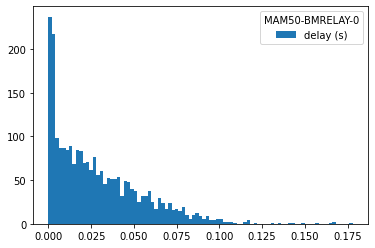

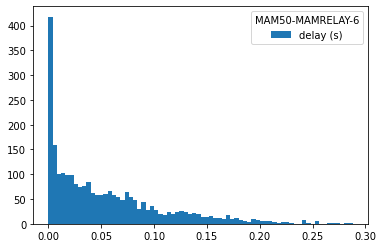

In [27]:

plt.hist(bins=hist.binedges, x=hist.binedges[:-1], weights=hist.binvalues, label="delay (s)")
plt.legend(title=runPrefix)
plt.show()

plt.hist(bins=hist2.binedges, x=hist2.binedges[:-1], weights=hist2.binvalues, label="delay (s)")
plt.legend(title=run2Prefix)
plt.show()

In [28]:
hist = endToEndDelayHistograms[endToEndDelayHistograms['run'].str.startswith(runPrefix, na=False)].iloc[0]
hist

run                    MAM50-BMRELAY-0-20200913-16:29:42-158790
type                                                  histogram
module                                  MAM50.collector1.app[0]
name                                    endToEndDelay:histogram
attrname                                                    NaN
attrvalue                                                  None
value                                                       NaN
count                                                      2423
sumweights                                                  NaN
mean                                                  0.0285991
stddev                                                0.0259209
min                                                           0
max                                                    0.176865
binedges      [0.0, 0.002, 0.004, 0.006, 0.008, 0.01, 0.012,...
binvalues     [237.0, 217.0, 98.0, 87.0, 87.0, 85.0, 89.0, 6...
Name: 554259, dtype: object

In [29]:
str(100-energyConsumption2Sum/energyConsumptionSum*100) + '% ' + run2Prefix + ' energy efficiency compared to ' + runPrefix

'5.886299400835483% MAM50-MAMRELAY-6 energy efficiency compared to MAM50-BMRELAY-0'

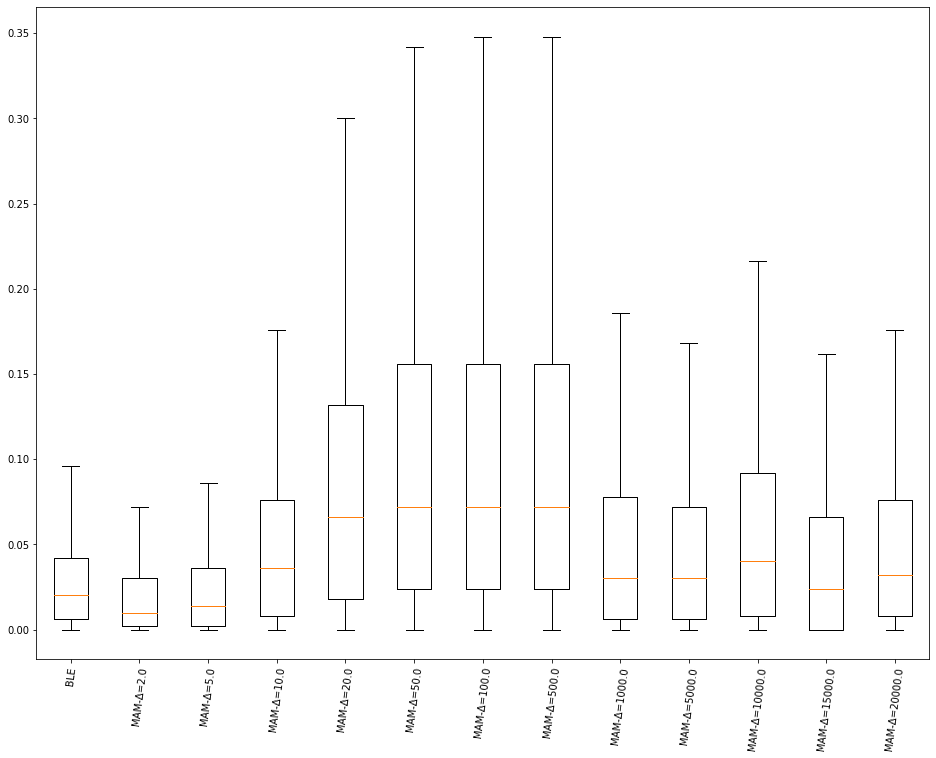

In [30]:
def explodeHistogramData(histogram):
    a = []

    i = 0
    for aa in histogram.binedges[:-1]:
        for j in range(1,histogram.binvalues[i].astype(np.int)):
            a.append(aa)
        i = i + 1
    return a

# Create a figure instance
fig = plt.figure(1, figsize=(16, 12))

# Create an axes instance
ax = fig.add_subplot(111)

bmesh2mpsData = explodeHistogramData(getHistogramData(histogramName='endToEndDelay:histogram', 
                        runData=getRunData(findBluetoothRelayRun(speed=2, configName='MAM50-BMRELAY'))))
    
data_to_plot_2ms = [bmesh2mpsData]
labels = ['BLE']

for d in allDeltas:
    data_to_plot_2ms.append(explodeHistogramData(getHistogramData(histogramName='endToEndDelay:histogram', 
                        runData=getRunData(findMAMRelayRun(speed=2, delta=d, configName='MAM50-MAMRELAY')))))
    labels.append('MAM-Δ=' + str(d))

# Create the boxplot
bp = ax.boxplot(data_to_plot_2ms, showfliers=False)

ax.set_xticklabels(labels)
plt.xticks(rotation='82.5')

# Save the figure
fig.savefig('fig1.png', bbox_inches='tight')

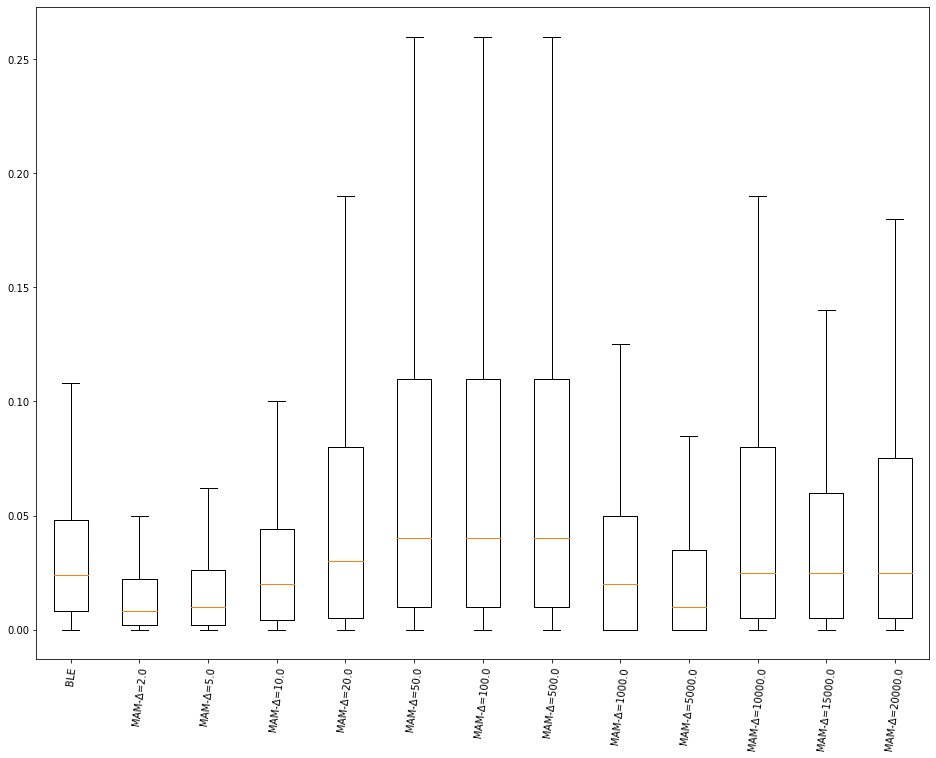

In [31]:
# Create a figure instance
fig = plt.figure(1, figsize=(16, 12))

# Create an axes instance
ax = fig.add_subplot(111)

bmesh6mpsData = explodeHistogramData(getHistogramData(histogramName='endToEndDelay:histogram', 
                        runData=getRunData(findBluetoothRelayRun(speed=6, configName='MAM50-BMRELAY'))))
    
data_to_plot_6ms = [bmesh6mpsData]
labels = ['BLE']

for d in allDeltas:
    data_to_plot_6ms.append(explodeHistogramData(getHistogramData(histogramName='endToEndDelay:histogram', 
                        runData=getRunData(findMAMRelayRun(speed=6, delta=d, configName='MAM50-MAMRELAY')))))
    labels.append('MAM-Δ=' + str(d))

# Create the boxplot
bp = ax.boxplot(data_to_plot_6ms, showfliers=False)

ax.set_xticklabels(labels)
plt.xticks(rotation='82.5')

# Save the figure
fig.savefig('fig2.png', bbox_inches='tight')

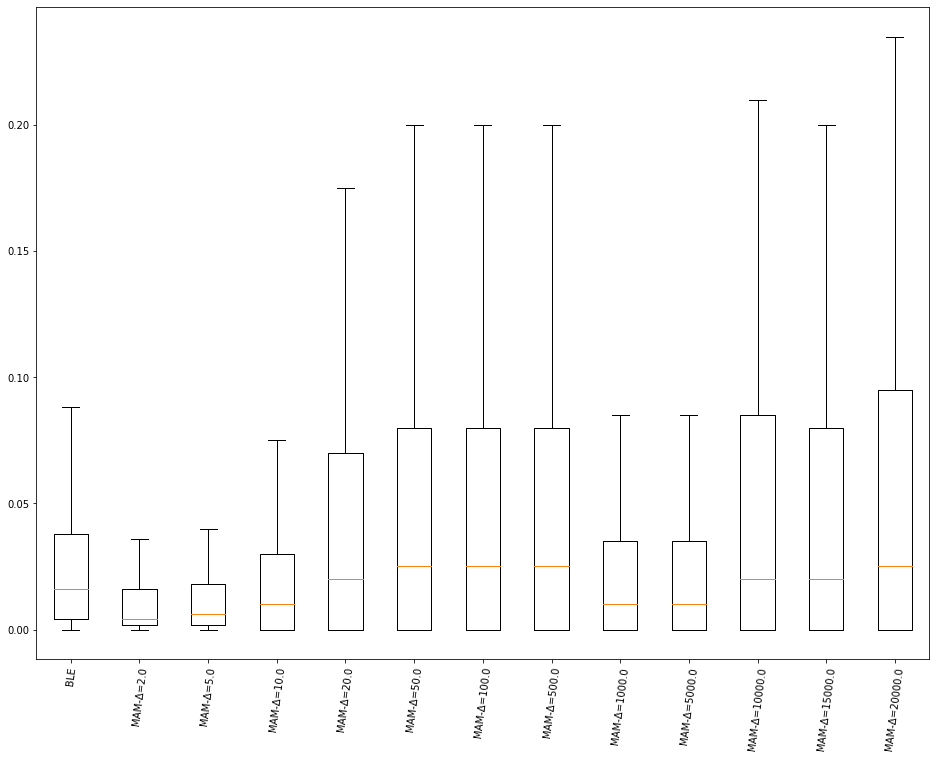

In [32]:
# Create a figure instance
fig = plt.figure(1, figsize=(16, 12))

# Create an axes instance
ax = fig.add_subplot(111)

bmesh14mpsData = explodeHistogramData(getHistogramData(histogramName='endToEndDelay:histogram', 
                        runData=getRunData(findBluetoothRelayRun(speed=14, configName='MAM50-BMRELAY'))))
    
data_to_plot_14ms = [bmesh14mpsData]
labels = ['BLE']

for d in allDeltas:
    data_to_plot_14ms.append(explodeHistogramData(getHistogramData(histogramName='endToEndDelay:histogram', 
                        runData=getRunData(findMAMRelayRun(speed=14, delta=d, configName='MAM50-MAMRELAY')))))
    labels.append('MAM-Δ=' + str(d))

# Create the boxplot
bp = ax.boxplot(data_to_plot_14ms, showfliers=False)

ax.set_xticklabels(labels)
plt.xticks(rotation='82.5')

# Save the figure
fig.savefig('fig3.png', bbox_inches='tight')

In [33]:
#TODO mhub data received bar chart. energy draw bar chart.

In [34]:
def getEnergyConsumptionData(speed):
    energyConsumptionSumBM = getScalarSum(scalarName='residualEnergyCapacity:last', 
                            runData=getRunData(findBluetoothRelayRun(speed=speed, configName='MAM50-BMRELAY')))


    labels = ['BM']
    values = [-energyConsumptionSum]

    for d in allDeltas:
        values.append(-getScalarSum(scalarName='residualEnergyCapacity:last', 
                            runData=getRunData(findMAMRelayRun(speed=speed, delta=d, configName='MAM50-MAMRELAY'))))
        labels.append('MAM-Δ=' + str(d))
    return [labels, values]

[labels, values] = getEnergyConsumptionData(2)

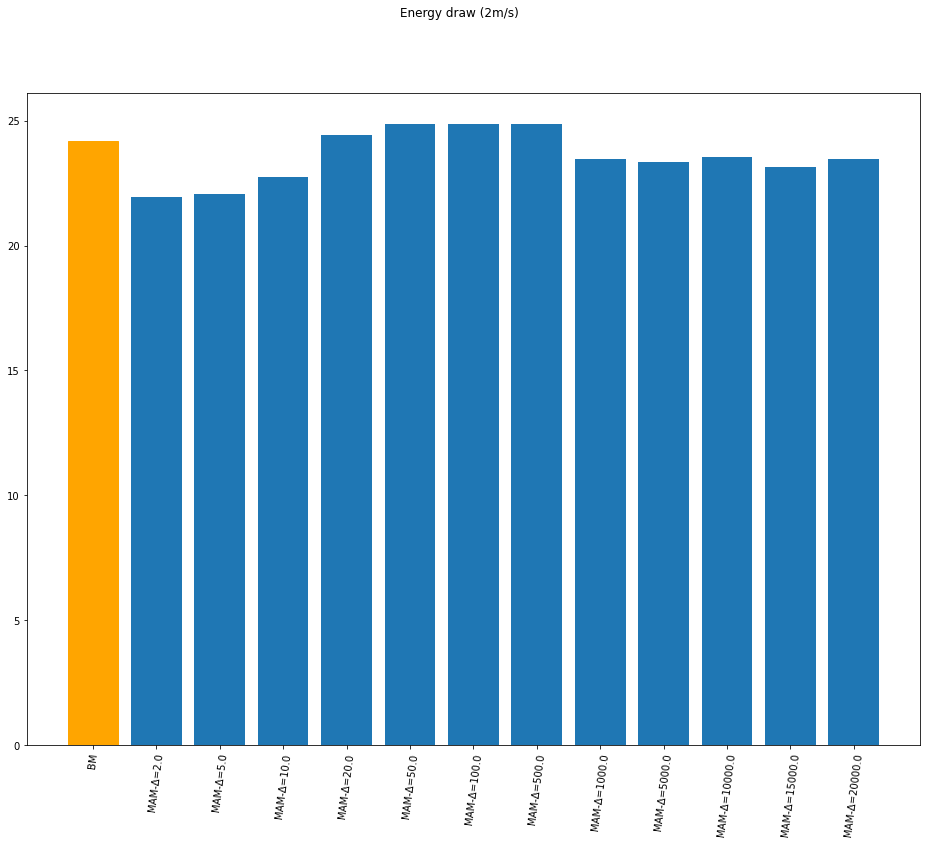

In [35]:
def plotEnergyConsumptionData(labels, values, speed, imageIdx):
    # Create a figure instance
    fig = plt.figure(1, figsize=(16, 12))

    # Create an axes instance
    ax = fig.add_subplot(111)

    # Create the barchart
    bp = ax.bar(labels, values)
    bp[0].set_color('orange')

    plt.suptitle('Energy draw (' + str(speed) + 'm/s)')
    plt.xticks(rotation='82.5')

    # Save the figure
    fig.savefig('fig' + str(imageIdx) + '.png', bbox_inches='tight')
    
plotEnergyConsumptionData(labels, values, 2, 4)

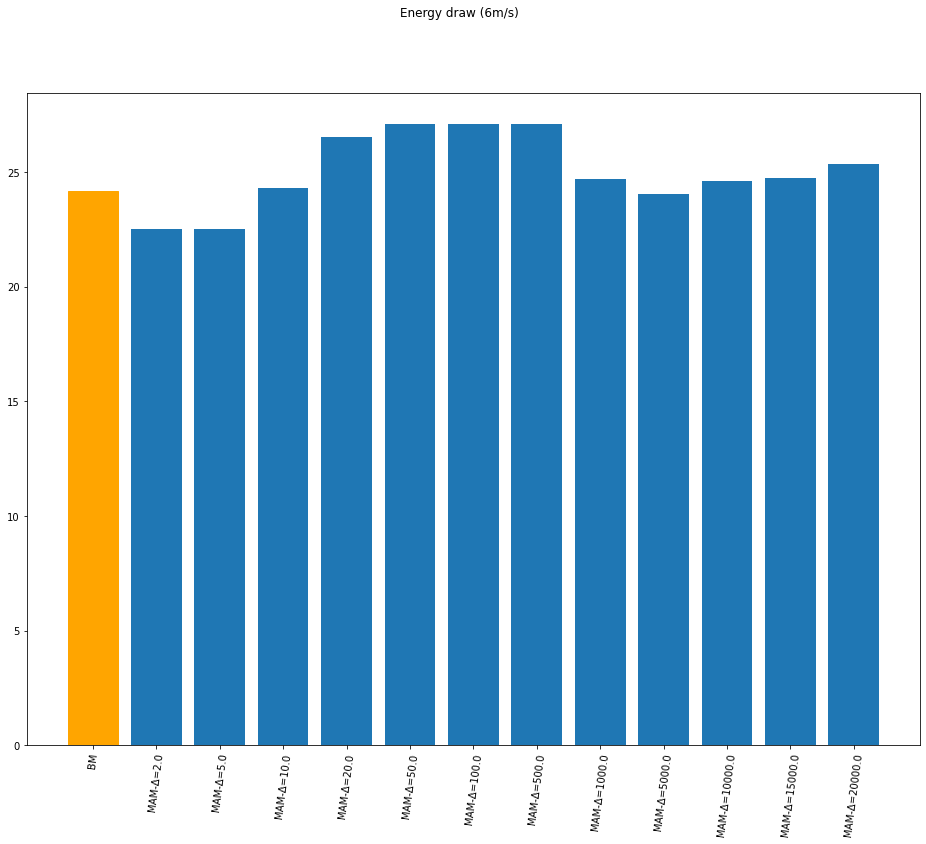

In [36]:
[labels, values] = getEnergyConsumptionData(6)
plotEnergyConsumptionData(labels, values, 6, 5)

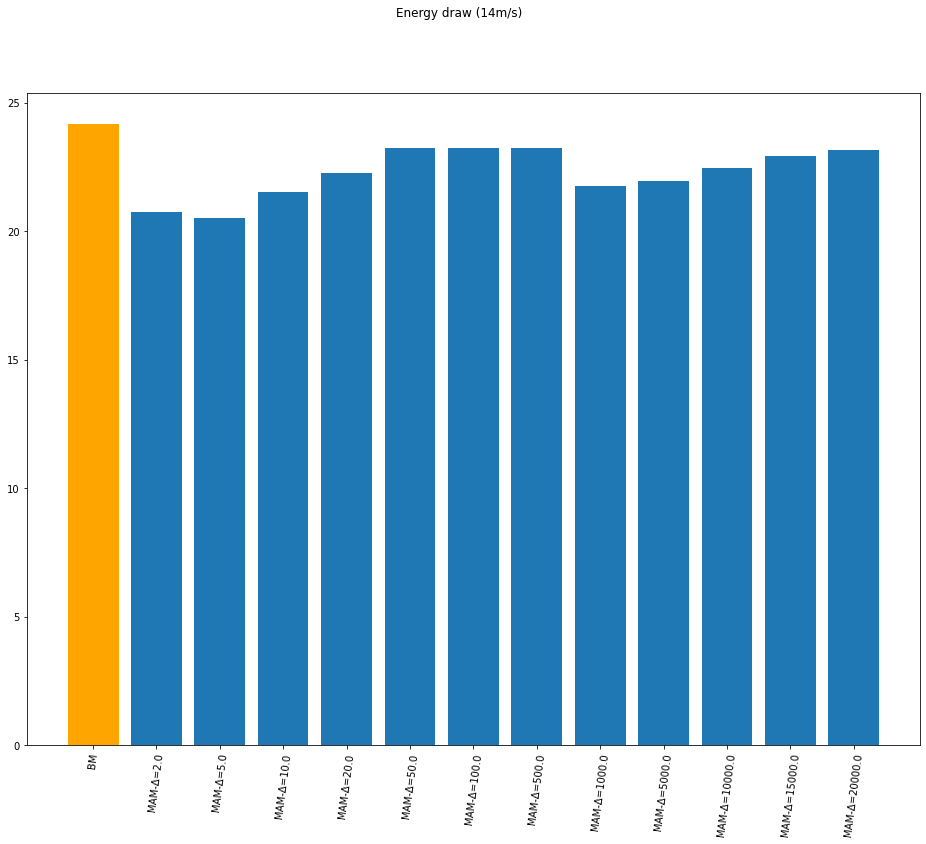

In [37]:
[labels, values] = getEnergyConsumptionData(14)
plotEnergyConsumptionData(labels, values, 14, 6)

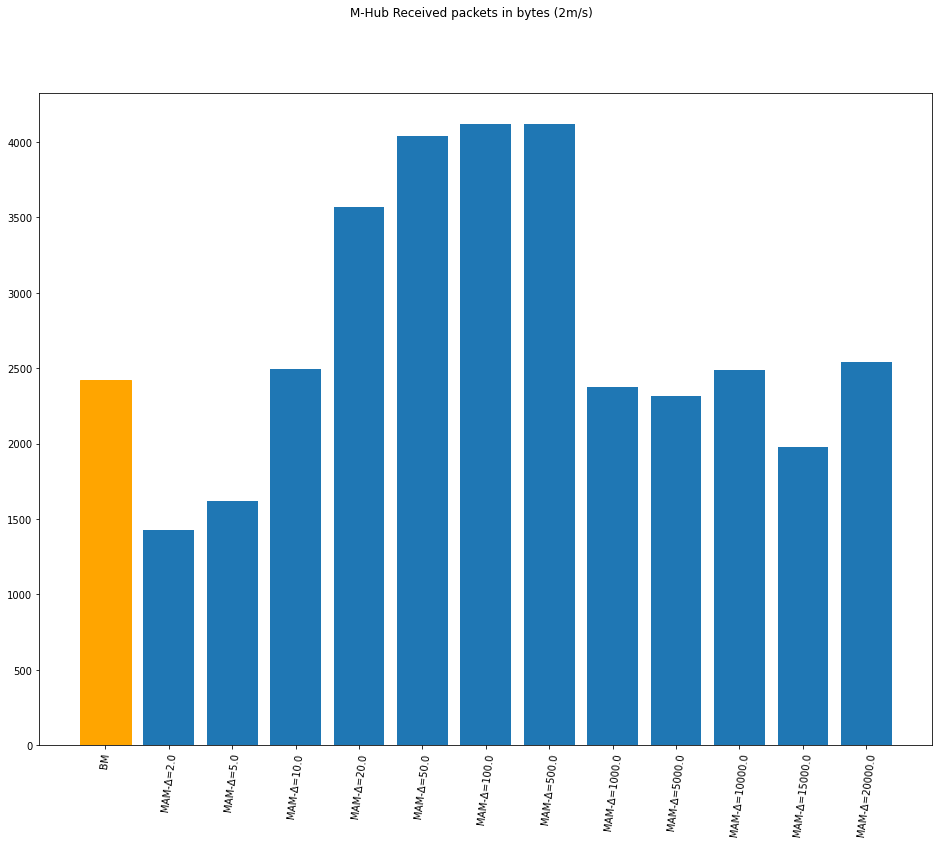

In [38]:
def getCollectorPacketsReceivedData(speed):
    bmData = getUniqueScalarValue(scalarName='packetReceived:count', 
                            scalarData=getCollectorRunScalars(findBluetoothRelayRun(speed=speed, configName='MAM50-BMRELAY')))


    labels = ['BM']
    values = [bmData]

    for d in allDeltas:
        values.append(getUniqueScalarValue(scalarName='packetReceived:count', 
                            scalarData=getCollectorRunScalars(findMAMRelayRun(speed=speed, delta=d, configName='MAM50-MAMRELAY'))))
        labels.append('MAM-Δ=' + str(d))
    return [labels, values]

def plotPacketsReceivedData(labels, values, speed, imageIdx):
    # Create a figure instance
    fig = plt.figure(1, figsize=(16, 12))

    # Create an axes instance
    ax = fig.add_subplot(111)

    # Create the barchart
    bp = ax.bar(labels, values)
    bp[0].set_color('orange')

    plt.suptitle('M-Hub Received packets in bytes (' + str(speed) + 'm/s)')
    plt.xticks(rotation='82.5')

    # Save the figure
    fig.savefig('fig' + str(imageIdx) + '.png', bbox_inches='tight')
    
[labels, values] = getCollectorPacketsReceivedData(2)
plotPacketsReceivedData(labels, values, 2, 7)

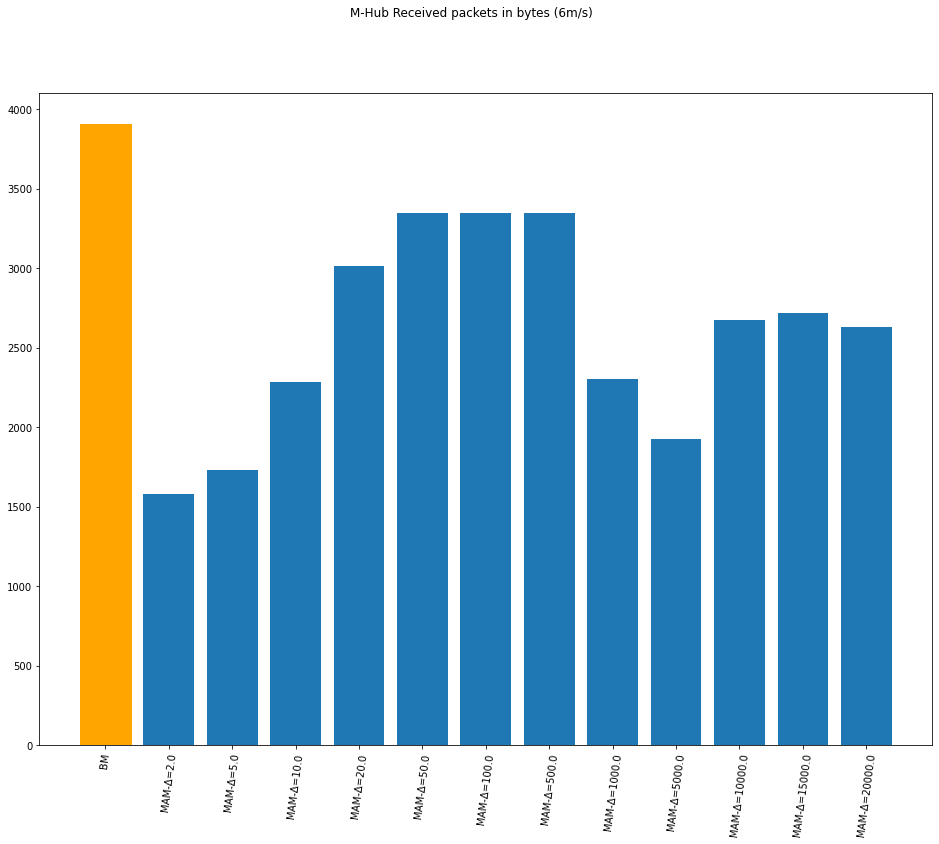

In [39]:

[labels, values] = getCollectorPacketsReceivedData(6)
plotPacketsReceivedData(labels, values, 6, 8)

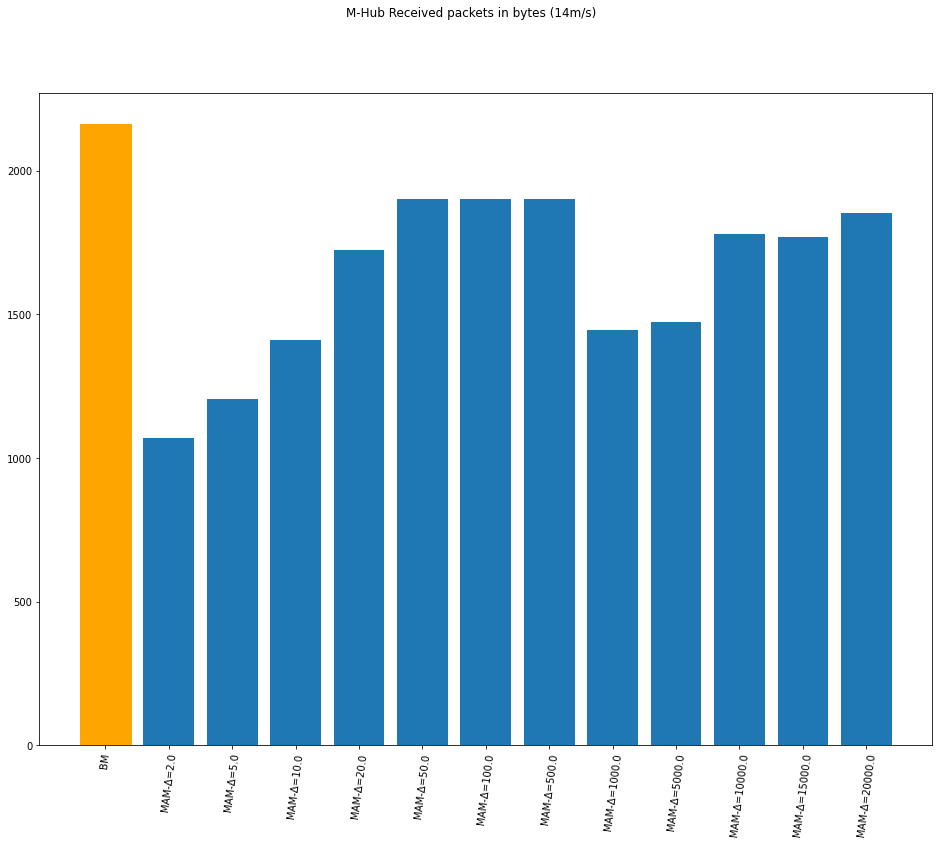

In [40]:

[labels, values] = getCollectorPacketsReceivedData(14)
plotPacketsReceivedData(labels, values, 14, 9)

In [41]:
def getReceivedPacketUUIDs(runData):
    packetUUIDs = set()

    data = runData[runData['name'].str.contains("received packet uuids-part1", na=False)]

    i = 1
    while len(data) > 0:
        if len(data) > 1:
            raise Exception('Error - non unique uuid part')

        key = data.iloc[0]['name']
        uuidsPartial = key.split('=')[1].split(',')
        packetUUIDs.update(uuidsPartial)
        i = i + 1
        data = runData[runData['name'].str.contains("received packet uuids-part" + str(i), na=False)]

    return packetUUIDs

def getGeneratedPacketUUIDs(runData):
    packetUUIDs = set()

    data = runData[runData['name'].str.contains("generated packet uuids", na=False)]['name']
    
    data.apply(lambda x: packetUUIDs.update(x.replace('generated packet uuids','').split(',')))
    
    return packetUUIDs

temp = getRunData(findMAMRelayRun(speed=2, delta=5, configName='MAM50-MAMRELAY'))
received = getReceivedPacketUUIDs(temp)
generated = getGeneratedPacketUUIDs(temp)

notReceivedPackets = generated.difference(received)

len(received)/len(generated)*100

21.839080459770116

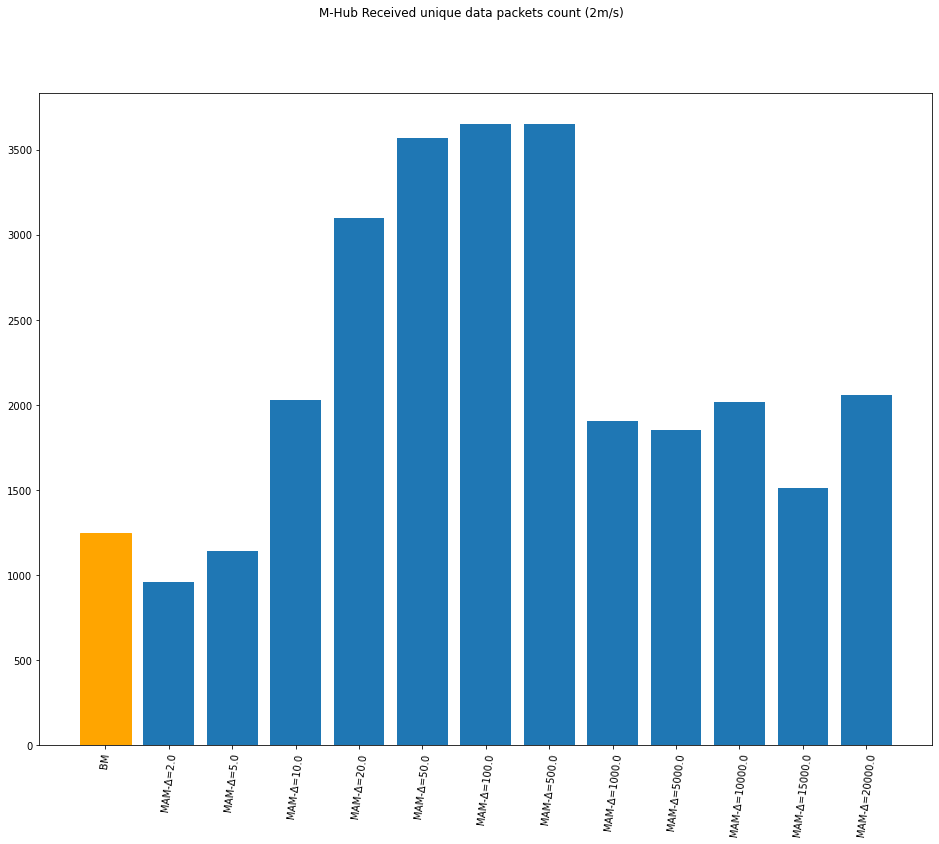

In [42]:
def getCollectorPacketsUniqueReceivedCount(speed):
    runData = getRunData(findBluetoothRelayRun(speed=speed, configName='MAM50-BMRELAY'))
    bmData = len(getReceivedPacketUUIDs(runData))


    labels = ['BM']
    values = [bmData]

    for d in allDeltas:
        runData = getRunData(findMAMRelayRun(speed=speed, delta=d, configName='MAM50-MAMRELAY'))
        values.append(len(getReceivedPacketUUIDs(runData)))
        labels.append('MAM-Δ=' + str(d))
    return [labels, values]

def plotPacketsUniqueReceivedCount(labels, values, speed, imageIdx):
    # Create a figure instance
    fig = plt.figure(1, figsize=(16, 12))

    # Create an axes instance
    ax = fig.add_subplot(111)

    # Create the barchart
    bp = ax.bar(labels, values)
    bp[0].set_color('orange')

    plt.suptitle('M-Hub Received unique data packets count (' + str(speed) + 'm/s)')
    plt.xticks(rotation='82.5')

    # Save the figure
    fig.savefig('fig' + str(imageIdx) + '.png', bbox_inches='tight')

[labels, values] = getCollectorPacketsUniqueReceivedCount(2)
plotPacketsUniqueReceivedCount(labels, values, 2, 10)

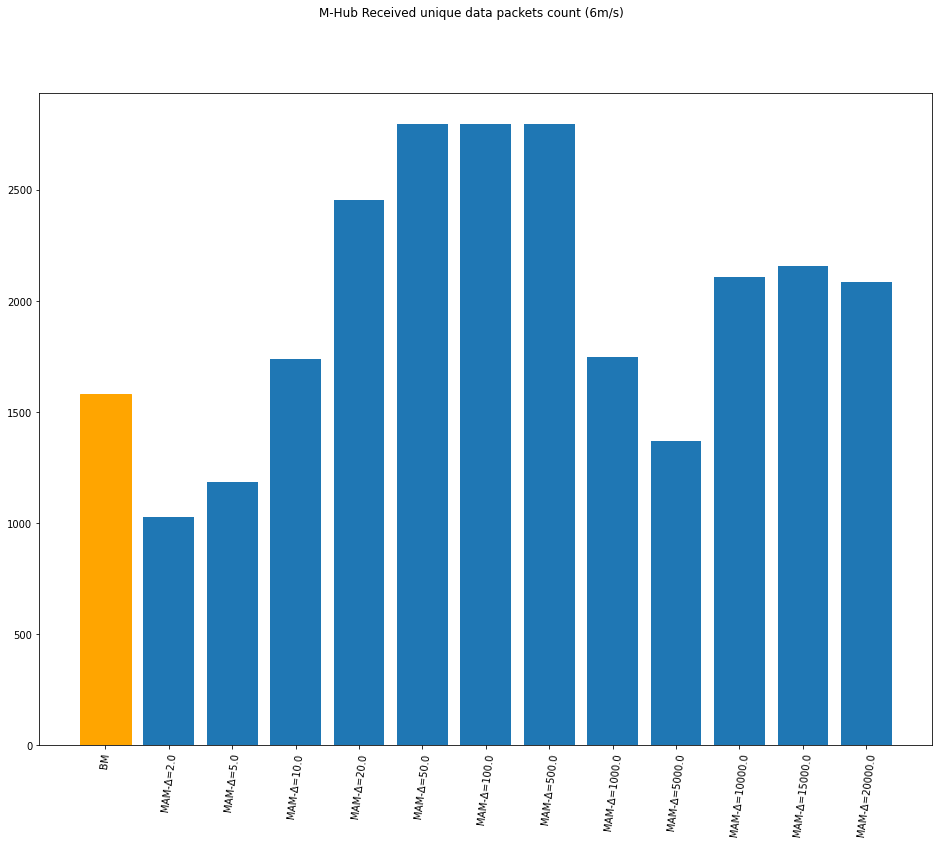

In [43]:
[labels, values] = getCollectorPacketsUniqueReceivedCount(6)
plotPacketsUniqueReceivedCount(labels, values, 6, 11)

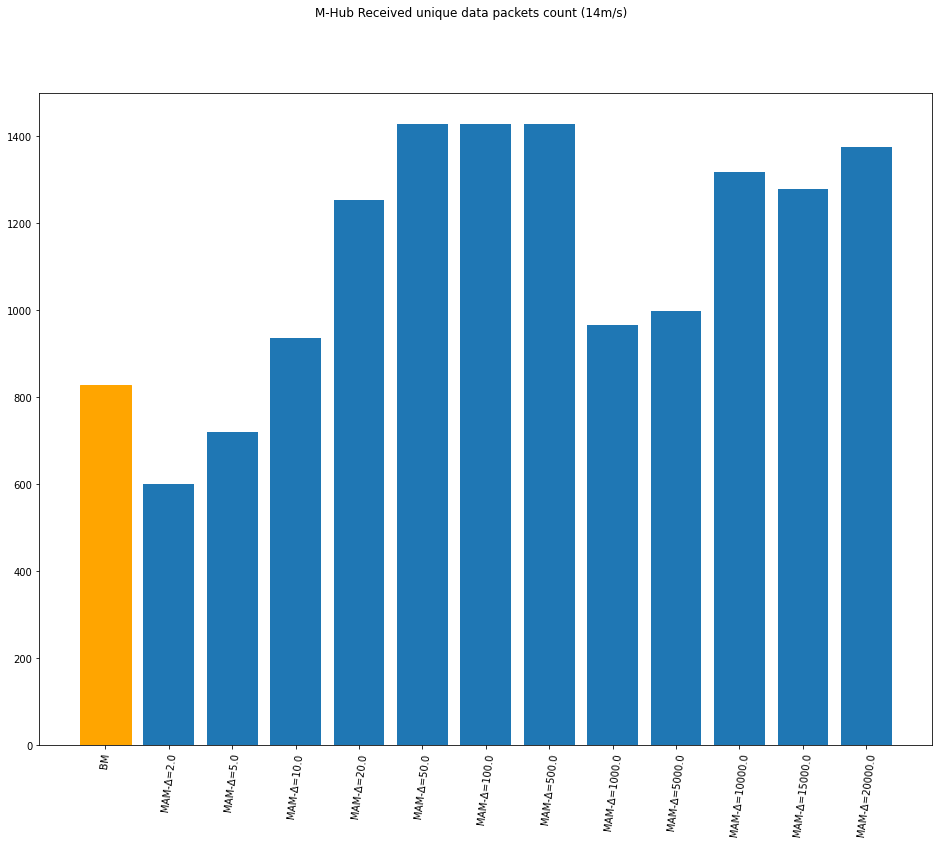

In [44]:
[labels, values] = getCollectorPacketsUniqueReceivedCount(14)
plotPacketsUniqueReceivedCount(labels, values, 14, 12)

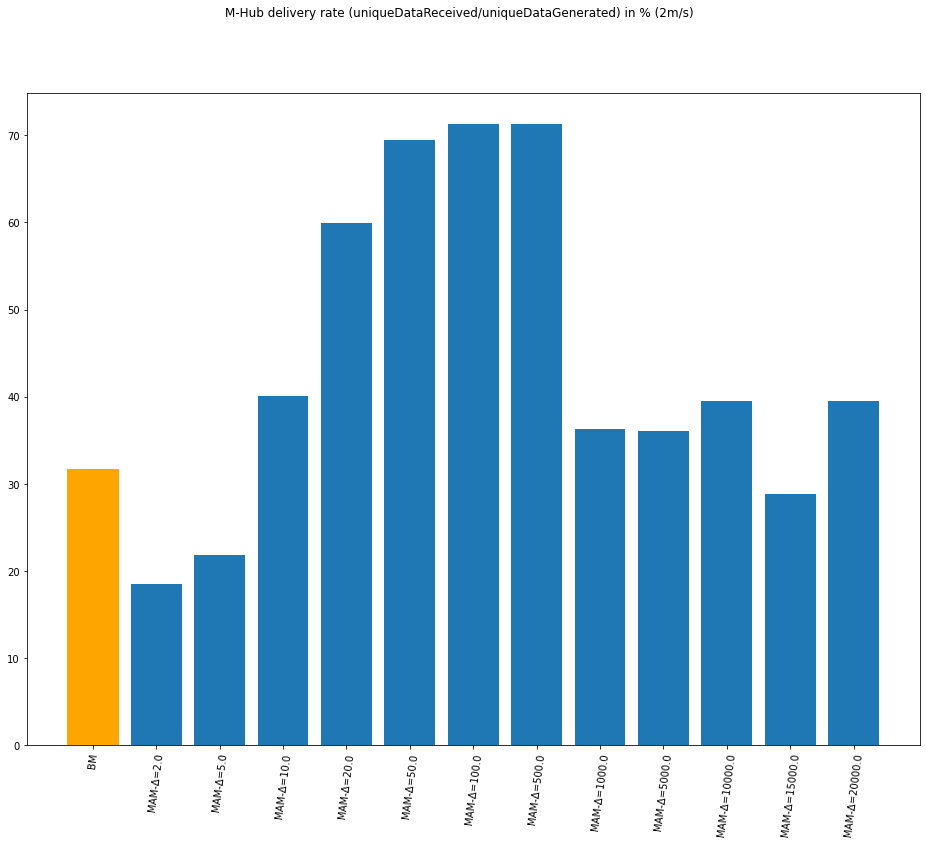

In [45]:
def getCollectorPacketsUniqueDeliveryRate(speed):
    runData = getRunData(findBluetoothRelayRun(speed=speed, configName='MAM50-BMRELAY'))
    bmData = len(getReceivedPacketUUIDs(runData))/len(getGeneratedPacketUUIDs(runData))*100


    labels = ['BM']
    values = [bmData]

    for d in allDeltas:
        runData = getRunData(findMAMRelayRun(speed=speed, delta=d, configName='MAM50-MAMRELAY'))
        values.append(len(getReceivedPacketUUIDs(runData))/len(getGeneratedPacketUUIDs(runData))*100)
        labels.append('MAM-Δ=' + str(d))
    return [labels, values]

def plotPacketsUniqueDeliveryRate(labels, values, speed, imageIdx):
    # Create a figure instance
    fig = plt.figure(1, figsize=(16, 12))

    # Create an axes instance
    ax = fig.add_subplot(111)

    # Create the barchart
    bp = ax.bar(labels, values)
    bp[0].set_color('orange')

    plt.suptitle('M-Hub delivery rate (uniqueDataReceived/uniqueDataGenerated) in % (' + str(speed) + 'm/s)')
    plt.xticks(rotation='82.5')

    # Save the figure
    fig.savefig('fig' + str(imageIdx) + '.png', bbox_inches='tight')

[labels, values] = getCollectorPacketsUniqueDeliveryRate(2)
plotPacketsUniqueDeliveryRate(labels, values, 2, 13)

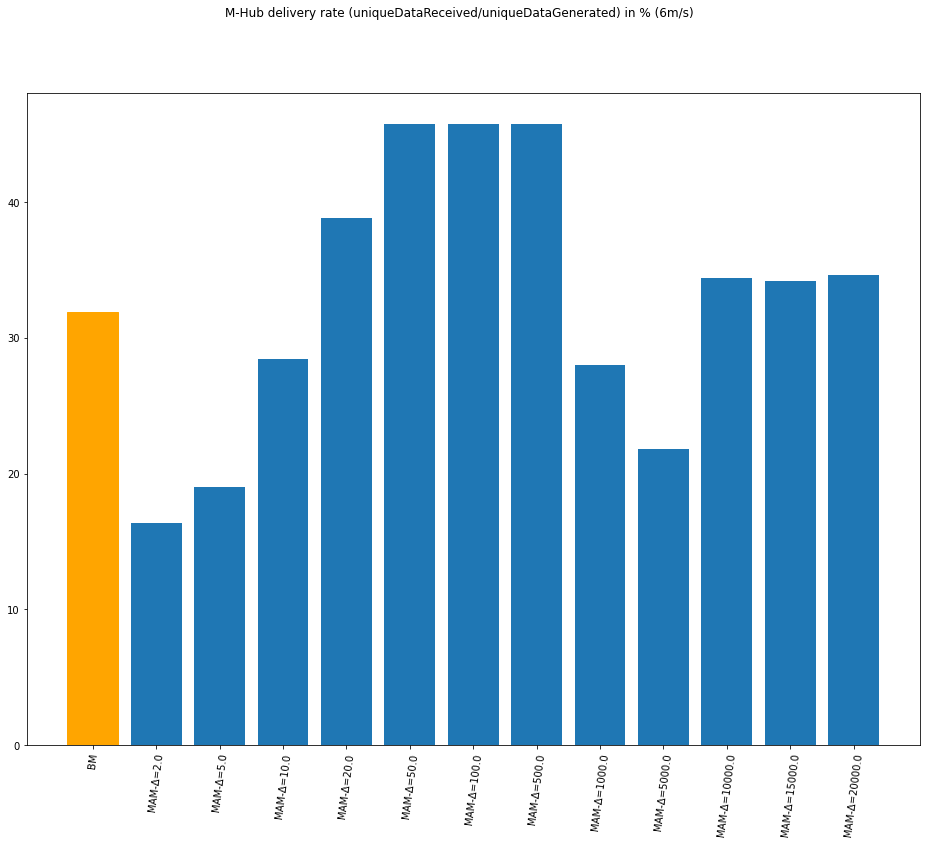

In [46]:

[labels, values] = getCollectorPacketsUniqueDeliveryRate(6)
plotPacketsUniqueDeliveryRate(labels, values, 6, 14)

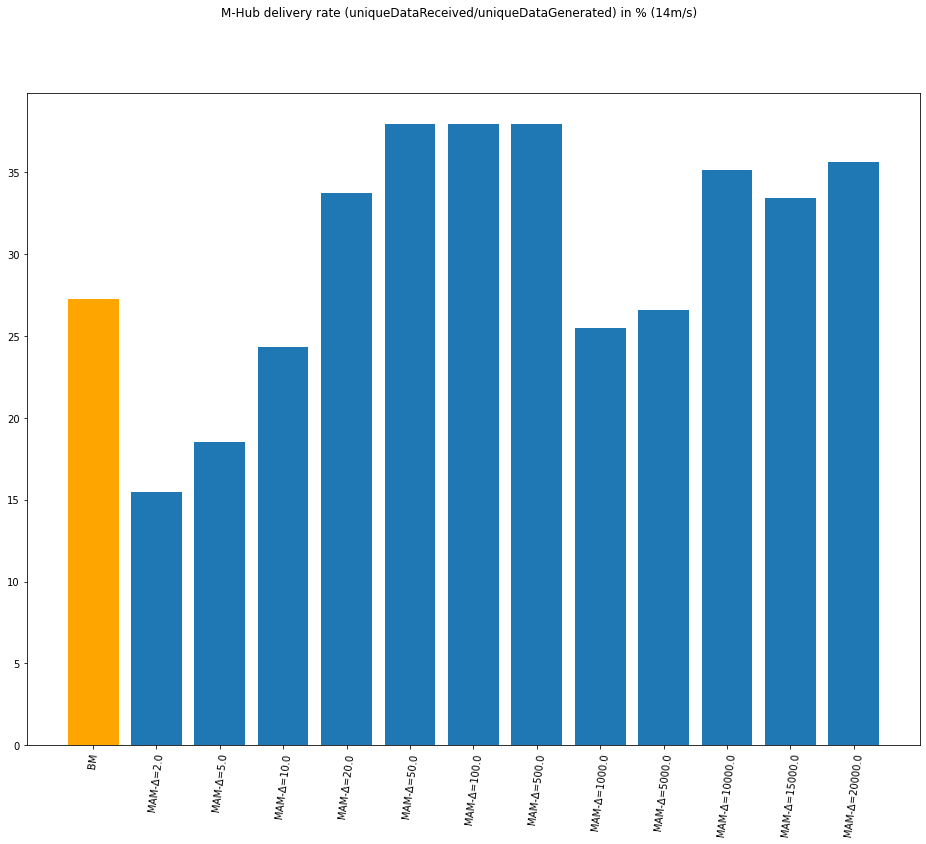

In [47]:

[labels, values] = getCollectorPacketsUniqueDeliveryRate(14)
plotPacketsUniqueDeliveryRate(labels, values, 14, 15)